# Statistical Analysis of the *La Permanence* dataset

## Imports

In [1]:
import datetime
import os
import itertools
import pytz
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
nb_minutes = 10
FREQ = f'{nb_minutes}T'
DAY_SEASONALITY = (60//nb_minutes)*24 # if FREQ is 10 minutes
WEEK_SEASONALITY = DAY_SEASONALITY*7
tz_utc = pytz.timezone("UTC")
tz_paris = pytz.timezone("Europe/Paris")

## Load data

In [3]:
dwnld_beg = datetime.datetime.now()
filepath = '/Users/antoine/Projects/la_permanence/attendance.csv'
filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=',')
dwnld_end = datetime.datetime.now()
print("Data loaded in {0} sec.".format((dwnld_end - dwnld_beg).seconds))
print("Shape of dataframe: {0}.".format(raw_data.shape))

Size of data file: 319KB.
Loading data...
Data loaded in 0 sec.
Shape of dataframe: (12332, 3).


## Preprocessing

Adjust for timezones:

In [4]:
attendance = raw_data.copy()

attendance['timestamp'] = attendance['timestamp'].apply(
    lambda s: pd.Timestamp(
        *tuple(map(int, s.split("-")))
    )
)
attendance['timestamp'] = attendance['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))


In [5]:
attendance.head()

,timestamp,Moulin,Alésia
0,2019-01-08 15:49:06+01:00,4,9
1,2019-01-08 15:52:00+01:00,4,6
2,2019-01-08 15:53:00+01:00,4,6
3,2019-01-08 15:54:00+01:00,4,6
4,2019-01-08 15:55:01+01:00,4,6


Set `timestamp` to index:

In [6]:
attendance.set_index("timestamp", inplace=True)

In [7]:
attendance.head()

,Moulin,Alésia
timestamp,,
2019-01-08 15:49:06+01:00,4,9
2019-01-08 15:52:00+01:00,4,6
2019-01-08 15:53:00+01:00,4,6
2019-01-08 15:54:00+01:00,4,6
2019-01-08 15:55:01+01:00,4,6


Time regularization:

In [8]:
attendance = attendance.resample(FREQ).mean().interpolate()

In [9]:
attendance.head()

,Moulin,Alésia
timestamp,,
2019-01-08 15:40:00+01:00,4.000,9.000
2019-01-08 15:50:00+01:00,4.125,5.375
2019-01-08 16:00:00+01:00,6.500,2.800
2019-01-08 16:10:00+01:00,5.400,0.700
2019-01-08 16:20:00+01:00,1.500,0.000


Set `freq`: 

In [10]:
attendance = attendance.asfreq(FREQ)

In [11]:
#attendance.index

In [12]:
attendance.head()

,Moulin,Alésia
timestamp,,
2019-01-08 15:40:00+01:00,4.000,9.000
2019-01-08 15:50:00+01:00,4.125,5.375
2019-01-08 16:00:00+01:00,6.500,2.800
2019-01-08 16:10:00+01:00,5.400,0.700
2019-01-08 16:20:00+01:00,1.500,0.000


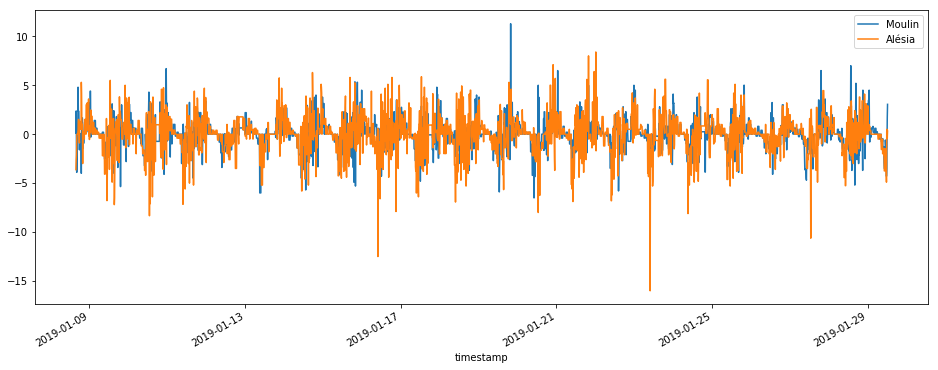

In [13]:
attendance.diff().plot(figsize=(16, 6));

In [14]:
attendance.diff().corr()

,Moulin,Alésia
Moulin,1.00000,0.30904
Alésia,0.30904,1.00000


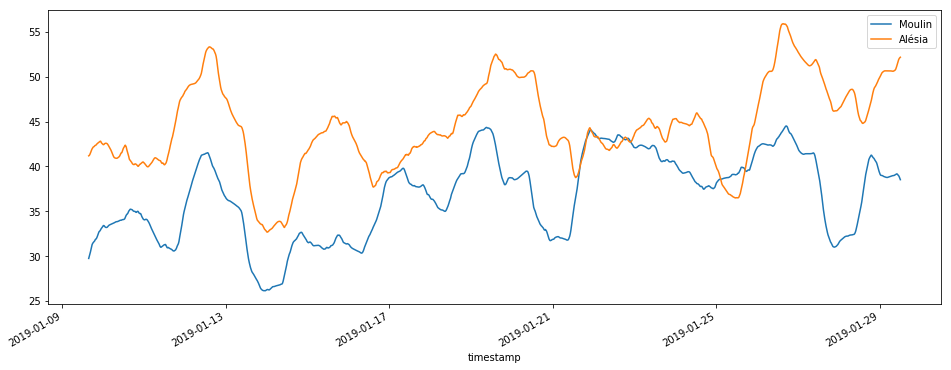

In [15]:
attendance.rolling(DAY_SEASONALITY).mean().plot(figsize=(16, 6));

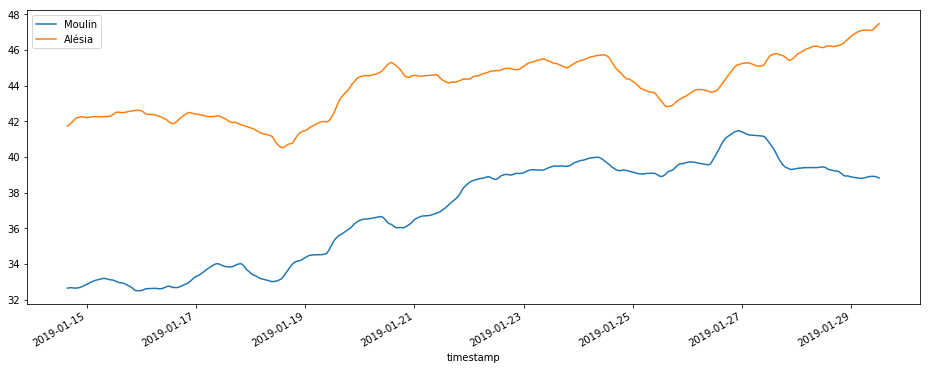

In [16]:
attendance.rolling(6*DAY_SEASONALITY).mean().plot(figsize=(16, 6));

In [17]:
#attendance.rolling(DAY_SEASONALITY).mean().plot(x='Moulin', y='Alésia', kind="scatter", style=".", figsize=(16, 6));

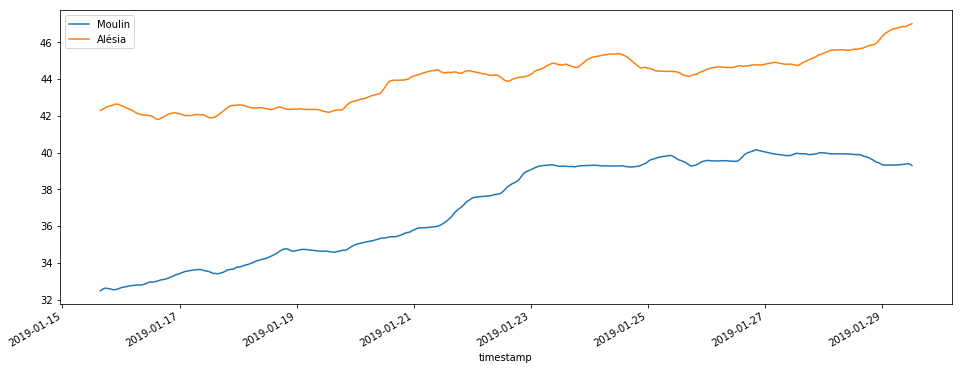

In [18]:
attendance.rolling(WEEK_SEASONALITY).mean().plot(figsize=(16, 6));

In [19]:
#attendance.rolling(WEEK_SEASONALITY).mean().plot(x='Moulin', y='Alésia', kind="scatter", style=".", figsize=(4, 4));

# Extract data for location at *rue du Fer à Moulin*

In [20]:
values = attendance['Moulin'].values
#idx = pd.Index(attendance['timestamp'])
idx = pd.DatetimeIndex(attendance.index)
moulin = pd.Series(values, index=idx)
moulin.iloc[-10:]

timestamp
2019-01-29 10:40:00+01:00    33.70
2019-01-29 10:50:00+01:00    33.10
2019-01-29 11:00:00+01:00    32.10
2019-01-29 11:10:00+01:00    30.60
2019-01-29 11:20:00+01:00    29.70
2019-01-29 11:30:00+01:00    25.40
2019-01-29 11:40:00+01:00    21.90
2019-01-29 11:50:00+01:00    21.00
2019-01-29 12:00:00+01:00    22.70
2019-01-29 12:10:00+01:00    25.75
Freq: 10T, dtype: float64

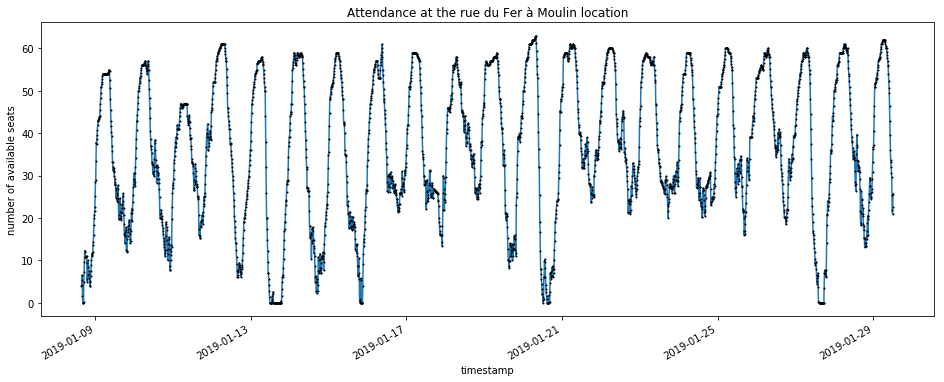

In [21]:
fig, ax = plt.subplots(figsize=(16, 6));
moulin.plot(ax=ax, style='-o', **{"markersize": 1, "markerfacecolor": "k", "markeredgecolor": "k"});
plt.ylabel("number of available seats");
plt.title('Attendance at the rue du Fer à Moulin location')
ax.legend().remove()

# Seasonal decomposition

### One-day seasonality

In [22]:
day_decomposition = sm.tsa.seasonal_decompose(moulin, model='additive', freq=DAY_SEASONALITY)

In [23]:
#fig, ax = plt.subplots(figsize=(16, 6));
#day_decomposition.plot();

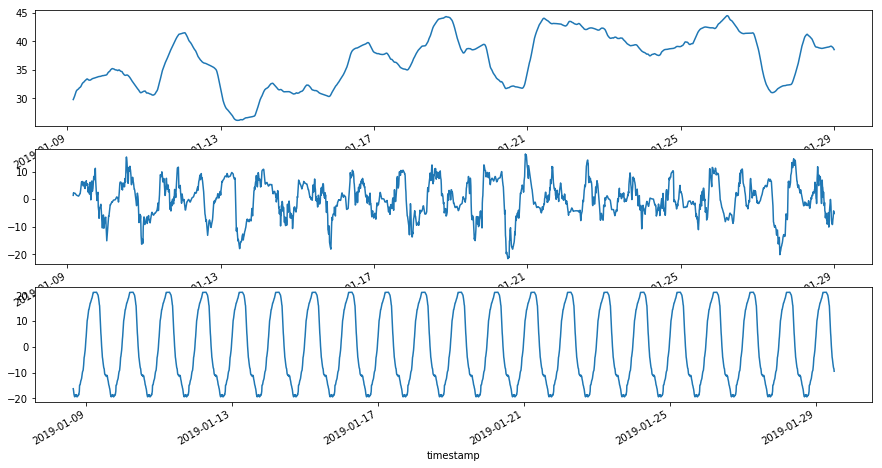

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8));
day_decomposition.trend.plot(ax=ax1);
day_decomposition.resid.plot(ax=ax2);
day_decomposition.seasonal.plot(ax=ax3);

### One-week seasonality

In [25]:
week_decomposition = sm.tsa.seasonal_decompose(moulin, model='additive', freq=WEEK_SEASONALITY)

In [26]:
#fig, ax = plt.subplots(figsize=(16, 6));
#week_decomposition.plot();

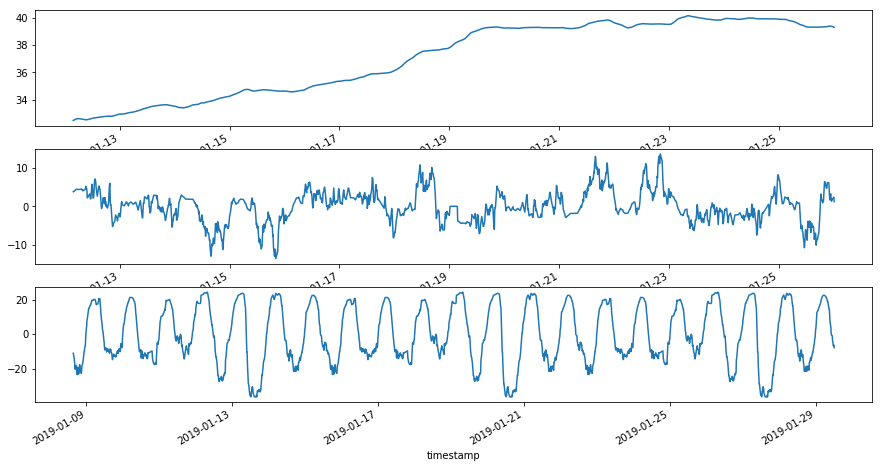

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8));
week_decomposition.trend.plot(ax=ax1);
week_decomposition.resid.plot(ax=ax2);
week_decomposition.seasonal.plot(ax=ax3);

# Autocorrelation

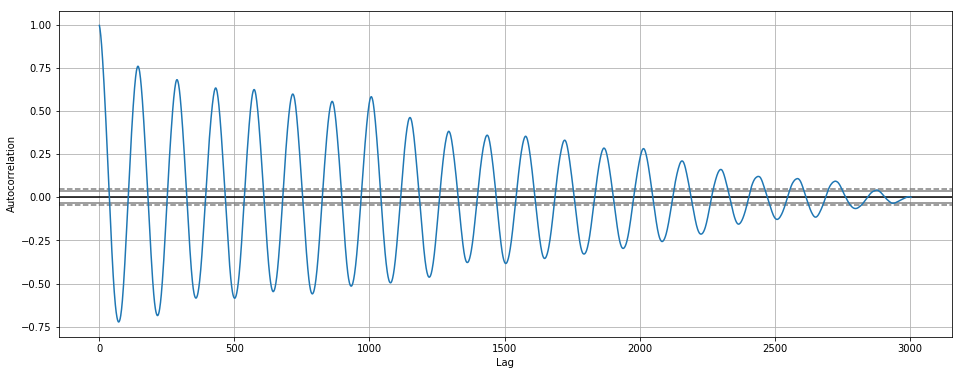

In [28]:
fig, ax = plt.subplots(figsize=(16, 6));
pd.plotting.autocorrelation_plot(moulin, ax=ax);

In [29]:
len(moulin)

3004